# **Facets tutorial**
In this Jupyter tutorial you can learn how to use one of the most sofisticated transformations that PyOskar provides: _facet()_. As every transformation this method pertains to _Oskar()_ class and we can acces to it through our _oskar_ instance.
> <span style="color:#ff6600"> **PyOskar is integrated in PySpark default API. It is possible to manage data simultaneously with functions from both libraries in case we want to select specific fields, visualize the dataframe, filter the output or performing other operations besides the transformation.** </span>
<br>

Usage:
```python
facet(df[DataFrame], facet[str])
```

First, we need to import the PyOskar and PySpark modules. Second, we need to create an instance of the _Oskar_ object, from which depends a big part of the functionality. Finally, we must use the _load()_ transformer pointing to where the parquet file is stored to convert our data into a DataFrame _df_, and we are ready to start playing.

In [2]:
from pyoskar.core import Oskar
from pyoskar.sql import *
from pyoskar.analysis import *
from pyspark.sql.functions import *

oskar = Oskar(spark)
df = oskar.load("./data/platinum_chr22.small.parquet")

You can use PySpark _show()_ method to print the data from _df_. This is how our testing dataframe looks like. As you can see for this tutorial we have selected a small dataset from Illumina Platinum Genomes with 1,000 random variants from chromosome 22.

In [3]:
print("Print first 20 variants:")
df.show()

Print first 20 variants:
+---------------+-----+----------+--------+--------+---------+---------+------+----+------+-----+----+--------------------+--------------------+
|             id|names|chromosome|   start|     end|reference|alternate|strand|  sv|length| type|hgvs|             studies|          annotation|
+---------------+-----+----------+--------+--------+---------+---------+------+----+------+-----+----+--------------------+--------------------+
|22:16054454:C:T|   []|        22|16054454|16054454|        C|        T|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16054454, 16...|
|22:16065809:T:C|   []|        22|16065809|16065809|        T|        C|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16065809, 16...|
|22:16077310:T:A|   []|        22|16077310|16077310|        T|        A|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16077310, 16...|
|22:16080499:A:G|   []|        22|16080499|16080499|        A|        G|     +|null|     1|  SNV|  []|[[h

NOTE: With _df.printSchema()_ command you can check the dataset hierarchy and all its fields.

In [4]:
print("Total number of variants:")
df.count()

Total number of variants:


1000

## Simple facets
We will start with an easy facet. This example executes the classics _groupBy()_ and _count()_ upon our dataframe. This format was designed to be applied on categorical or discrete quantitative variables. That could be any among these ones:
 - Chromosome [<span style="color:#ff6600"> **chromosome** </span>]
 - Variant type [<span style="color:#ff6600"> **type** </span>]
 - Studies [<span style="color:#ff6600"> **studies** </span>]
 - Biotype [<span style="color:#ff6600"> **biotype** </span>]
 - Consequence type [<span style="color:#ff6600"> **ct** </span>]
 - Gene [<span style="color:#ff6600"> **gene** </span>]
 - Ensemble gene ID [<span style="color:#ff6600"> **ensemblGeneId** </span>]
 - Ensemble gene transcript [<span style="color:#ff6600"> **ensemblTranscriptId** </span>]

In [5]:
oskar.facet(df, "type").show()

+-----+-----+
| type|count|
+-----+-----+
|INDEL|  106|
|  SNV|  894|
+-----+-----+



In [40]:
oskar.facet(df, "ct").show(truncate = False)

+----------------------------------+-----+
|ct                                |count|
+----------------------------------+-----+
|2KB_downstream_variant            |146  |
|2KB_upstream_variant              |146  |
|3_prime_UTR_variant               |9    |
|5_prime_UTR_variant               |1    |
|NMD_transcript_variant            |140  |
|TF_binding_site_variant           |108  |
|downstream_gene_variant           |163  |
|intergenic_variant                |222  |
|intron_variant                    |543  |
|missense_variant                  |4    |
|non_coding_transcript_exon_variant|45   |
|non_coding_transcript_variant     |385  |
|regulatory_region_variant         |764  |
|splice_donor_variant              |1    |
|splice_region_variant             |2    |
|synonymous_variant                |6    |
|upstream_gene_variant             |200  |
+----------------------------------+-----+



## Include facets
We can also apply a filtering based on the values we do explicit in the function.

In [41]:
oskar.facet(df, "gene[BCL2L13,CECR2]").show()

+-------+-----+
|   gene|count|
+-------+-----+
|BCL2L13|    8|
|  CECR2|   11|
+-------+-----+



## Range facets
Using a similar syntax as with _Include facets_ but dealing with continuous quantitative variables we find that we can apply facets by range, where we can determine both upper and downer thresholds as well as the step e.g. _[start..end]:step_. Available range fields are:
 - Conservation scores: grep [<span style="color:#ff6600"> **grep** </span>], phylop [<span style="color:#ff6600"> **phylop** </span>] or phastCons [<span style="color:#ff6600"> **phastCons** </span>]
 - Functional scores: cadd_scaled [<span style="color:#ff6600"> **cadd_scaled** </span>] or cadd_raw [<span style="color:#ff6600"> **cadd_raw** </span>]
 - Substitution scores: sift [<span style="color:#ff6600"> **sift** </span>] or polyphen [<span style="color:#ff6600"> **polyphen** </span>]

In [44]:
oskar.facet(df, "phylop[-5..0]:1").show()

+-----------+-----+
|phylopRange|count|
+-----------+-----+
|       -4.0|    3|
|       -3.0|   12|
|       -2.0|   55|
|       -1.0|  171|
|        0.0|  681|
+-----------+-----+



Furthermore, we dispose two more rangeable fields where we could use our facets. These ones have the peculiarity that they need extra inputs to be fully defined; we will need to explicit the study which they pertain and the cohort delimited by two underscores. These fields are:
 - Global alternate population frequency [<span style="color:#ff6600"> **popFreq** </span>] 
 - Dataframe alternate population frequency [<span style="color:#ff6600"> **stats** </span>]
<br>

NOTE: _stats facet_ needs a previous step carried out by _stats_ transformer that generates new data inside the DataFrame, and whose functionality is fully explained in the _Stats tutorial_.

In [18]:
facetDF = oskar.facet(df, "popFreq__GNOMAD_GENOMES__ALL[0..1]:0.1")
facetDF.select(col("popFreq__GNOMAD_GENOMES__ALLRange").alias("popFreq__GNOMAD_GENOMES__ALL"), "count").show()

+----------------------------+-----+
|popFreq__GNOMAD_GENOMES__ALL|count|
+----------------------------+-----+
|                         0.0|  514|
|                         0.1|  112|
|                         0.2|   75|
|         0.30000000000000004|   97|
|                         0.4|   77|
|                         0.5|   26|
|          0.6000000000000001|   35|
|          0.7000000000000001|   23|
|                         0.8|   18|
|                         0.9|   15|
|                         1.0|    8|
+----------------------------+-----+



In [5]:
statsDF = oskar.stats(df)
facetDF = oskar.facet(statsDF, "stats__hgvauser@platinum:illumina_platinum__ALL[0..1]:0.1")
facetDF.select(col("stats__hgvauser@platinum:illumina_platinum__ALLRange").alias("stats__hgvauser@platinum:illumina_platinum__ALL"),"count").show()

+-----------------------------------------------+-----+
|stats__hgvauser@platinum:illumina_platinum__ALL|count|
+-----------------------------------------------+-----+
|                                            0.0|   41|
|                                            0.1|   15|
|                                            0.2|   14|
|                            0.30000000000000004|   10|
|                                            0.4|    7|
|                                            0.5|  714|
|                             0.6000000000000001|   68|
|                             0.7000000000000001|   49|
|                                            0.8|   12|
|                                            0.9|   21|
|                                            1.0|   48|
+-----------------------------------------------+-----+



## Aggregation facets
Facets also provide the option of substituting the _count()_ function by these other mathematical operations:
 - Average [<span style="color:#ff6600"> **avg** </span>]
 - Maximum [<span style="color:#ff6600"> **max** </span>]
 - Minimum [<span style="color:#ff6600"> **min** </span>]
 - Sumatory [<span style="color:#ff6600"> **sum** </span>]
 - Squared sumatory [<span style="color:#ff6600"> **sumsq** </span>]
 - Standard deviation [<span style="color:#ff6600"> **stddev** </span>]
 - Variance [<span style="color:#ff6600"> **var** </span>]
 - Percentile values [<span style="color:#ff6600"> **percentile** </span>]
 - Set of values [<span style="color:#ff6600"> **unique** </span>]

In [6]:
oskar.facet(df, "avg(gerp)").show(truncate = False)

+-------------------+-----+
|avg(gerp)          |count|
+-------------------+-----+
|-0.3518712293113349|1000 |
+-------------------+-----+



In [7]:
oskar.facet(df, "percentile(gerp)").show(truncate = False)

+---------------------------------------------------------------------------------------+-----+
|percentile(gerp)                                                                       |count|
+---------------------------------------------------------------------------------------+-----+
|[-2.152000093460083, -0.6257500052452087, 0.0, 0.14900000393390656, 0.7430999755859375]|1000 |
+---------------------------------------------------------------------------------------+-----+



## Nested facets
Nesting allows us to concatenate gruops and reach complex studies by using ">>" separator.

In [52]:
oskar.facet(df, "biotype>>ct[splice_donor_variant]").show(truncate = False)

+-----------------------+--------------------+-----+
|biotype                |ct                  |count|
+-----------------------+--------------------+-----+
|nonsense_mediated_decay|splice_donor_variant|1    |
|processed_transcript   |splice_donor_variant|1    |
|protein_coding         |splice_donor_variant|1    |
|retained_intron        |splice_donor_variant|1    |
+-----------------------+--------------------+-----+



## Final facets
Now it is up to us to mix all these ingredients:

In [122]:
oskar.facet(df, "gene[AIFM3,GGT1]>>biotype>>cadd_raw[-10..10]:0.2>>cadd_scaled[-10..10]:1>>min(phylop)").show(25, truncate = False)

+-----+-----------------------+-------------+----------------+--------------------+-----+
|gene |biotype                |cadd_rawRange|cadd_scaledRange|min(phylop)         |count|
+-----+-----------------------+-------------+----------------+--------------------+-----+
|AIFM3|lincRNA                |0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|nonsense_mediated_decay|0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|processed_transcript   |0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|protein_coding         |0.2          |6.0             |-0.2809999883174896 |1    |
|AIFM3|retained_intron        |0.2          |6.0             |-0.2809999883174896 |1    |
|GGT1 |nonsense_mediated_decay|-0.2         |0.0             |-1.1380000114440918 |2    |
|GGT1 |nonsense_mediated_decay|0.0          |1.0             |0.10199999809265137 |2    |
|GGT1 |nonsense_mediated_decay|0.0          |2.0             |0.054999999701976776|1    |
|GGT1 |non

In [96]:
snvPandas = oskar.facet(df, "type[SNV]>>popFreq__GNOMAD_GENOMES__ALL[0..0.5]:0.1").show()
indelPandas = oskar.facet(df, "type[INDEL]>>popFreq__GNOMAD_GENOMES__ALL[0..0.5]:0.1").show()

+----+---------------------------------+-----+
|type|popFreq__GNOMAD_GENOMES__ALLRange|count|
+----+---------------------------------+-----+
| SNV|                              0.0|  478|
| SNV|                              0.1|   95|
| SNV|                              0.2|   57|
| SNV|              0.30000000000000004|   90|
| SNV|                              0.4|   66|
| SNV|                              0.5|   21|
+----+---------------------------------+-----+

+-----+---------------------------------+-----+
| type|popFreq__GNOMAD_GENOMES__ALLRange|count|
+-----+---------------------------------+-----+
|INDEL|                              0.0|   36|
|INDEL|                              0.1|   17|
|INDEL|                              0.2|   18|
|INDEL|              0.30000000000000004|    7|
|INDEL|                              0.4|   11|
|INDEL|                              0.5|    5|
+-----+---------------------------------+-----+



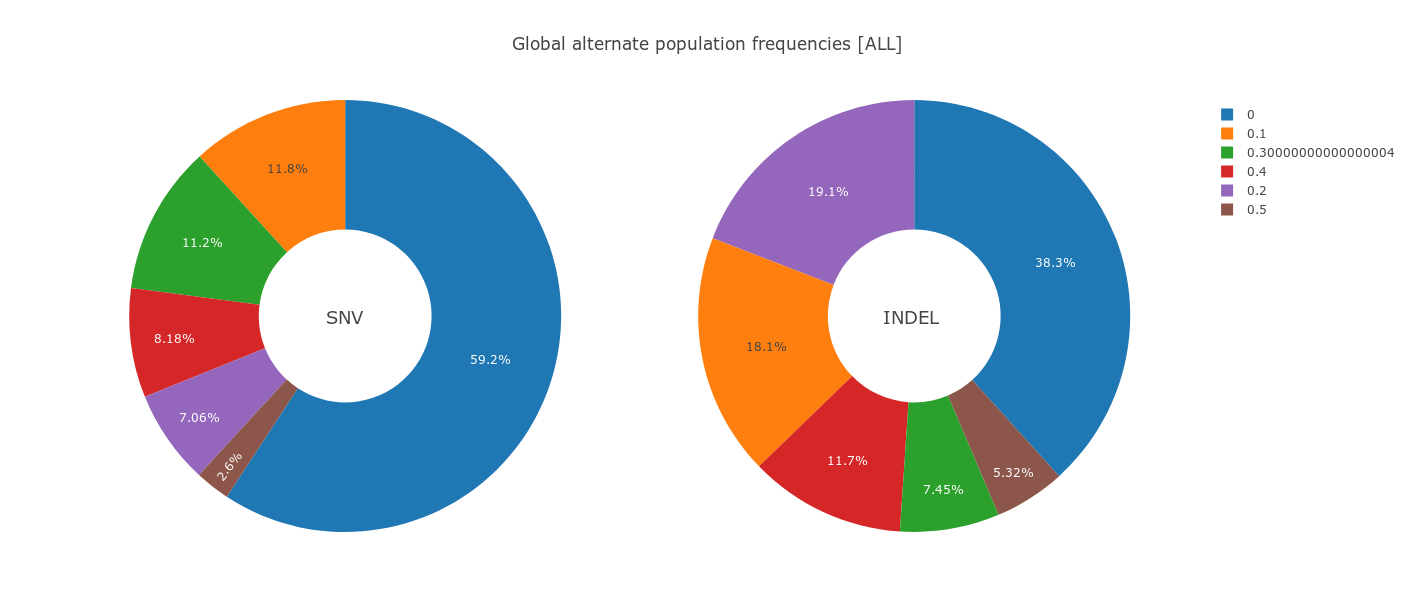

In [8]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import get_plotlyjs, init_notebook_mode

snvPandas = oskar.facet(df, "type[SNV]>>popFreq__GNOMAD_GENOMES__ALL[0..0.5]:0.1").toPandas()
indelPandas = oskar.facet(df, "type[INDEL]>>popFreq__GNOMAD_GENOMES__ALL[0..0.5]:0.1").toPandas()

init_notebook_mode(connected = True)

fig = {
  "data": [
    {
      "values": snvPandas["count"],
      "labels": snvPandas["popFreq__GNOMAD_GENOMES__ALLRange"],
      "domain": {"x": [0, .48]},
      "hole": .4,
      "type": "pie"
    },
    {
      "values": indelPandas["count"],
      "labels": indelPandas["popFreq__GNOMAD_GENOMES__ALLRange"],
      "domain": {"x": [.51, 1]},
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Global alternate population frequencies [ALL]",
        "autosize":False,
        "width":1500,
        "height":600,
        "annotations": [
            {
                "font": {
                    "size": 18
                },
                "showarrow": False,
                "text": "SNV",
                "x": 0.22,
                "y": 0.5
            },
            {
                "font": {
                    "size": 18
                },
                "showarrow": False,
                "text": "INDEL",
                "x": 0.78,
                "y": 0.5
            }
        ]
    }
}
py.iplot(fig, filename = 'donut')